# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Data Exploration - general population vs. customers

#### Load general population and customers dataset

In [2]:
# load in the data
# general population dataset
azdias_df = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

# customers dataset
customers_df = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/fc/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
azdias_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [6]:
customers_df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


`azdias_df` and `customers_df` have 366 common features, which is the same as `azdias_df` features.

In [7]:
np.intersect1d(azdias_df.columns.values, customers_df.columns.values).shape

(366,)

create `only_attr_customers` to hold `customer_df` only features

In [8]:
only_attr_customers = np.setdiff1d(customers_df.columns.values, azdias_df.columns.values)

CUSTOMER_GROUP distribution

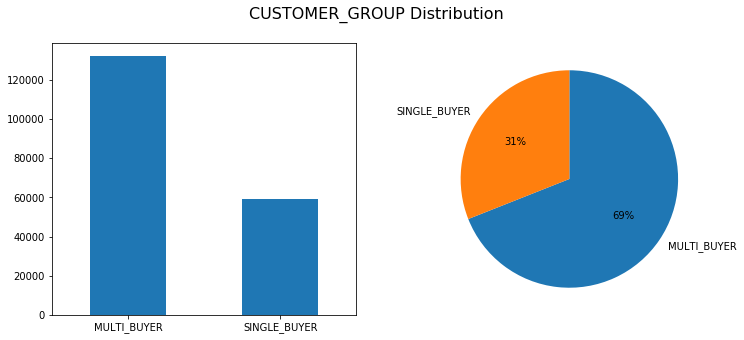

In [9]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.CUSTOMER_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.CUSTOMER_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('CUSTOMER_GROUP Distribution', fontsize=16)
plt.show()

ONLINE_PURCHASE distribution

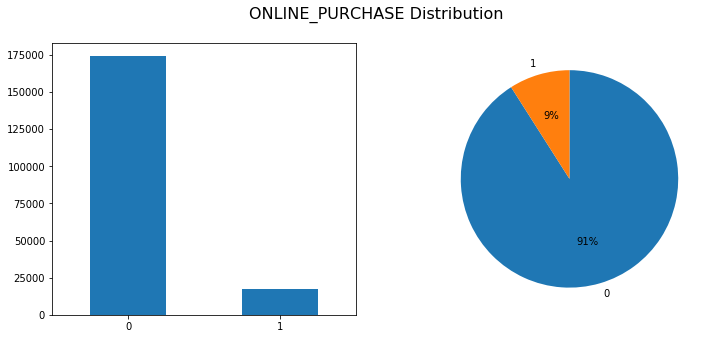

In [10]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.ONLINE_PURCHASE.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.ONLINE_PURCHASE.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('ONLINE_PURCHASE Distribution', fontsize=16)
plt.show()

PRODUCT_GROUP distribution

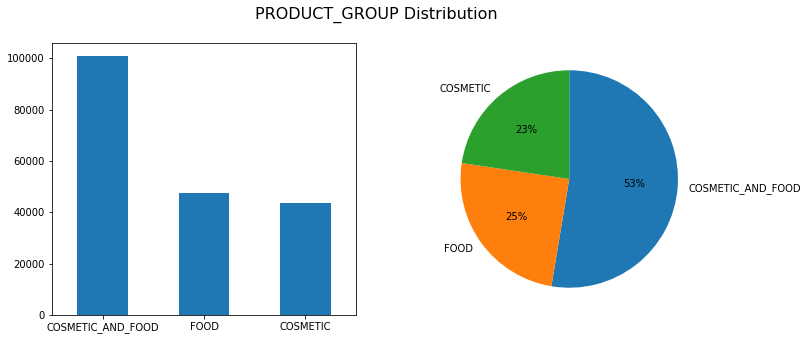

In [11]:
plt.subplots(1, 2, figsize = [12, 5])

plt.subplot(1, 2, 1)
customers_df.PRODUCT_GROUP.value_counts().plot.bar(rot=0)

plt.subplot(1, 2, 2)
customers_df.PRODUCT_GROUP.value_counts().plot.pie(autopct='%1.f%%', startangle = 90, counterclock = False).set_ylabel('')

plt.suptitle('PRODUCT_GROUP Distribution', fontsize=16)
plt.show()

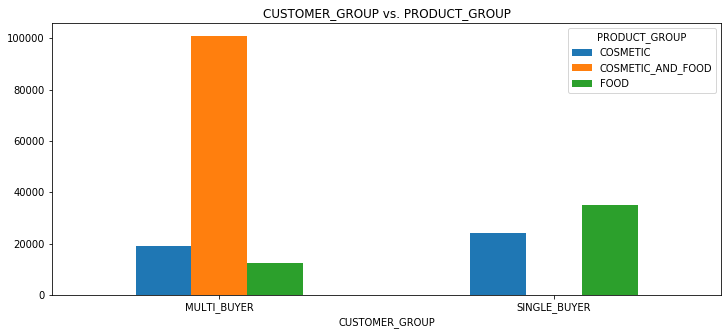

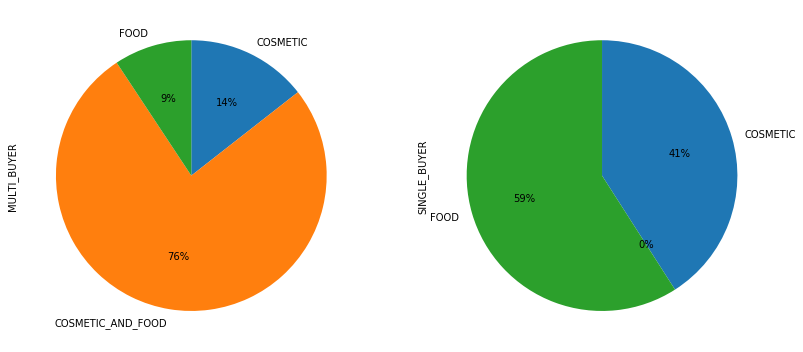

In [12]:
customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. PRODUCT_GROUP')

customers_df.groupby(['CUSTOMER_GROUP'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

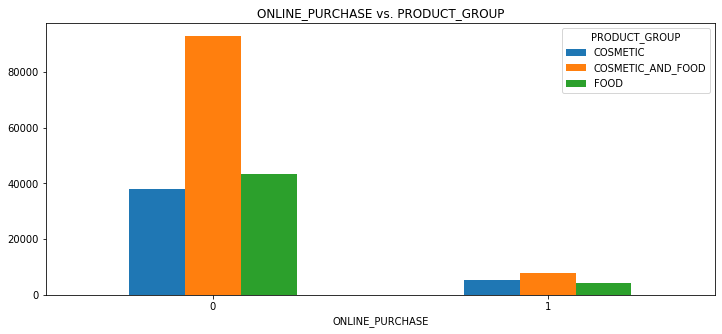

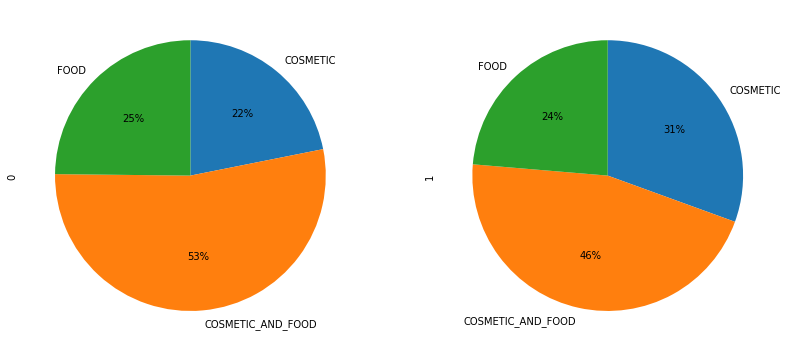

In [13]:
customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('ONLINE_PURCHASE vs. PRODUCT_GROUP')

customers_df.groupby(['ONLINE_PURCHASE'])['PRODUCT_GROUP'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

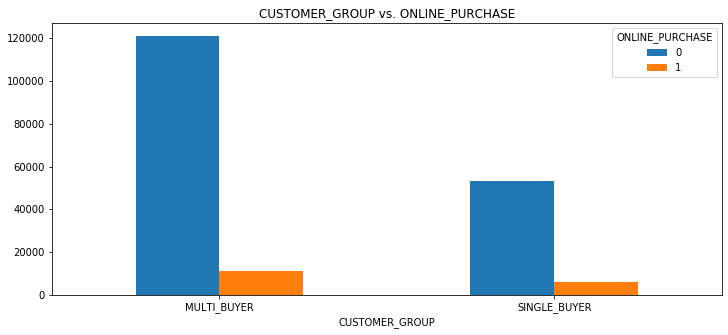

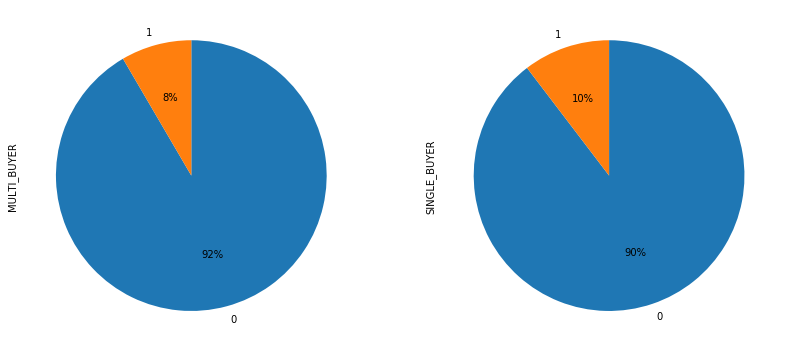

In [14]:
customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().plot.bar(figsize = [12, 5], rot=0).set_title('CUSTOMER_GROUP vs. ONLINE_PURCHASE')

customers_df.groupby(['CUSTOMER_GROUP'])['ONLINE_PURCHASE'].value_counts().unstack().T.plot.pie(subplots=True, autopct='%1.f%%', figsize=[12,5], legend=False, startangle = 90, counterclock = False)

plt.tight_layout()
plt.show()

### Data Exploration - Attributes vs. Values

#### Load attributes dataset

In [15]:
# attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1, index_col=[1]).reset_index()
del attributes_df['Unnamed: 0']
attributes_df.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [16]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
Information level    312 non-null object
Attribute            313 non-null object
Description          313 non-null object
Additional notes     20 non-null object
dtypes: object(4)
memory usage: 9.9+ KB


#### Load values dataset

In [17]:
# values dataset
values_df = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1, index_col=[1,2]).reset_index()
del values_df['Unnamed: 0']
values_df.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


In [18]:
values_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
Attribute      2258 non-null object
Description    2258 non-null object
Value          2258 non-null object
Meaning        2247 non-null object
dtypes: object(4)
memory usage: 70.6+ KB


In [19]:
# values_df only
np.setdiff1d(values_df.Attribute.unique(), attributes_df.Attribute)

array(['BIP_FLAG', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_LOTTO_RZ',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_VERSAND_ANZ_12',
       'D19_VERSAND_ANZ_24', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
       'KBA13_CCM_3000', 'KBA13_CCM_3001'], dtype=object)

In [20]:
# attributes_df only
np.setdiff1d(attributes_df.Attribute, values_df.Attribute.unique())

array(['ARBEIT', 'D19_BANKEN_ ANZ_12             D19_BANKEN_ ANZ_24',
       'D19_GESAMT_ANZ_12                                    D19_GESAMT_ANZ_24',
       'D19_TELKO_ ANZ_12                  D19_TELKO_ ANZ_24',
       'D19_VERSAND_ ANZ_12          D19_VERSAND_ ANZ_24',
       'D19_VERSI_ ANZ_12                                       D19_VERSI_ ANZ_24',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'],
      dtype=object)

From above, we can find attributes dataset features not normalized. We will use values dataset to query data, and merge attributes dataset feature to values.

Create `attr_only_attributes_not_values` to hold features only in `attributes_df` and not in `values_df`.

In [21]:
attr_only_attributes_not_values = np.array(['ARBEIT', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'EINWOHNER', 'GKZ', 'PLZ', 'PLZ8'])

creqte `annot_attribute` as combined features from `vlaues_df` and `attributes_df`.

In [22]:
annot_attribute = np.union1d(values_df.Attribute.unique(), attr_only_attributes_not_values)

We found `only_attr_customers` not in `annot_attribute`

In [23]:
np.isin(only_attr_customers, values_df.Attribute)

array([False, False, False])

#### Analyze feature type

Fina all value of `values_df`

##### Quantitative Feature

create `num_annot_attribute` to hold quantative features

We assume every quantative feature in `values_df` only have one column.

In [24]:
num_annot_attribute = values_df.Attribute.unique()[np.where(values_df.groupby(['Attribute'], sort=False)['Value'].count() == 1)]

##### Categorical Attribute

create `bin_cat_annot_attribute` to hold binary categorical features

In [25]:
bin_cat_annot_attribute = np.array(values_df.Attribute.unique()[np.where(values_df.groupby(['Attribute'])['Value'].count() == 2)])

create `str_cat_annot_attribute` to hold nominal categorical features

We found only OST_WEST_KZ and CAMEO_DEU_2015 have string value in `values_df`.

In [26]:
str_cat_annot_attribute = np.array(['OST_WEST_KZ'])

In [27]:
str_cat_annot_attribute = np.union1d(str_cat_annot_attribute, ['CAMEO_DEU_2015'])

create `num_cat_annot_attribute` to hold ordinal categorical features

In [28]:
_ = np.setdiff1d(values_df.Attribute, bin_cat_annot_attribute)
_ = np.setdiff1d(_, str_cat_annot_attribute)
_ = np.setdiff1d(_, num_annot_attribute)
num_cat_annot_attribute = values_df.loc[np.where(values_df.Attribute.isin(_))[0]].groupby(['Attribute'])['Value'].unique().index.values

In [29]:
assert values_df.Attribute.unique().size == num_annot_attribute.size + bin_cat_annot_attribute.size + str_cat_annot_attribute.size + num_cat_annot_attribute.size

We assue D19_VERSI_OFFLINE_DATUM, D19_VERSI_ONLINE_DATUM, D19_VERSI_DATUM are as same as D19_BANKEN_DATUM belongs to ordinal categorical feature.

In [30]:
num_cat_annot_attribute = np.union1d(num_cat_annot_attribute, ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM'])

We assume ARBEIT belongs to quantitative feature.

In [31]:
num_annot_attribute = np.union1d(num_annot_attribute, ['ARBEIT'])

We found PLZ, PLZ8, EINWOHNER, GKZ are unused features.

In [32]:
unused_annot_attribute = np.array(['PLZ', 'PLZ8', 'EINWOHNER', 'GKZ'])

In [33]:
assert annot_attribute.size == num_annot_attribute.size + bin_cat_annot_attribute.size + str_cat_annot_attribute.size + num_cat_annot_attribute.size + unused_annot_attribute.size

create `minus_1_0_unknown_annot_attribute` to hold '-1, 0' feature

In [34]:
minus_1_0_unknown_annot_attribute = values_df.loc[np.where(np.isin(values_df.Value, '-1, 0'))].Attribute.values

create `minus_1_9_unknown_annot_attribute` to hold '-1, 9' feature

In [35]:
minus_1_9_unknown_annot_attribute = values_df.loc[np.where(np.isin(values_df.Value, '-1, 9'))].Attribute.values

### Data Exploration - customers vs. values

#### COLUMN Veiewpoint

create `annot_attr_customers_values` to hold common features of `customer_df` and `annot_attribute`

In [36]:
annot_attr_customers_values = np.intersect1d(customers_df.columns.values, annot_attribute)

In [37]:
not_annot_attr_customers_values = np.setdiff1d(customers_df.columns.values, annot_attr_customers_values)

In [38]:
assert customers_df.columns.values.size == annot_attr_customers_values.size + not_annot_attr_customers_values.size

In [39]:
customers_df[annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 276 entries, AGER_TYP to ZABEOTYP
dtypes: float64(216), int64(57), object(3)
memory usage: 403.6+ MB


#### Check missing value

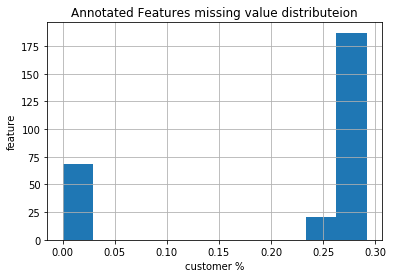

In [40]:
customers_df[annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('customer %')
plt.ylabel('feature')
plt.title('Annotated Features missing value distributeion')
plt.show()

We can find less than 30% csutomers have missing value among documented features.

REATURE DROP CRITERIA: __missing value customers % > 30%__

In [41]:
FEATURE_DROP_RATIO=.3

create `customers_unused_annot_attribute` to hold unused feature

In [42]:
customers_unused_annot_attribute = annot_attr_customers_values[customers_df[annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]

#### Check `bin_cat_annot_attribute`

create `customers_bin_cat_annot_attribute` to hold `bin_cat_annot_attribute` in `customers_df`

In [43]:
customers_bin_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, bin_cat_annot_attribute)
customers_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, customers_unused_annot_attribute)

In [44]:
for col in customers_bin_cat_annot_attribute:
    v1 = customers_df[col].unique()
    v2 = values_df[values_df.Attribute == col]['Value'].values
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

#### Check `str_cat_annot_attribute`

create `customers_str_cat_annot_attribute` to hold `str_cat_annot_attribute` in `customers_df`

In [45]:
customers_str_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, str_cat_annot_attribute)
customers_str_cat_annot_attribute = np.setdiff1d(customers_str_cat_annot_attribute, customers_unused_annot_attribute)

In [46]:
for col in customers_str_cat_annot_attribute:
    v1 = customers_df[col].unique()[~pd.isnull(customers_df[col].unique())]
    v2 = values_df[values_df.Attribute == col]['Value'].values.astype(str)
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

CAMEO_DEU_2015 feature has undocumented value: ['XX']


#### Check `num_cat_annot_attribute`

create `customers_num_cat_annot_attribute` to hold `num_cat_annot_attribute` in `customers_df`

In [47]:
customers_num_cat_annot_attribute = np.intersect1d(annot_attr_customers_values, num_cat_annot_attribute)
customers_num_cat_annot_attribute = np.setdiff1d(customers_num_cat_annot_attribute, customers_unused_annot_attribute)

In [48]:
for col in customers_num_cat_annot_attribute:
    
    unknown_v = []
    v1 = customers_df[col].dropna().apply(lambda x: unknown_v.append(x) if isinstance(x, str) else x).dropna().unique()
    
    # assue value of 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM' are as same as 'D19_BANKEN_DATUM'
    if col in ['D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_DATUM']:
        col = 'D19_BANKEN_DATUM'
        
    v2 = np.hstack(values_df[values_df.Attribute == col]['Value'].apply(lambda x: list(map(int, x.split(','))) if isinstance(x, str) else x).values)
    
    v = np.setdiff1d(v1, v2)
    unknown_v = np.unique(np.array(unknown_v))
    
    if len(unknown_v) > 0:
        print('{} feature has unknown value: {}'.format(col, unknown_v))
    if v.size > 0:
        print('{} feature has undocumented value: {}'.format(col, v))

CAMEO_DEUG_2015 feature has unknown value: ['1' '2' '3' '4' '5' '6' '7' '8' '9' 'X']
KBA05_MODTEMP feature has undocumented value: [6.]
LP_FAMILIE_FEIN feature has undocumented value: [0.]
LP_FAMILIE_GROB feature has undocumented value: [0.]
LP_LEBENSPHASE_FEIN feature has undocumented value: [0.]
LP_LEBENSPHASE_GROB feature has undocumented value: [0.]


#### Check `num_annot_attribute`

create `customers_num_annot_attribute` to hold `num_annot_attribute` in `customers_df`

In [49]:
customers_num_annot_attribute = np.intersect1d(annot_attr_customers_values, num_annot_attribute)
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, customers_unused_annot_attribute)

In [50]:
for col in customers_num_annot_attribute:
    if not np.issubdtype(customers_df[col].dtype, np.number):
        print('{} is not numberic type'.format(col))

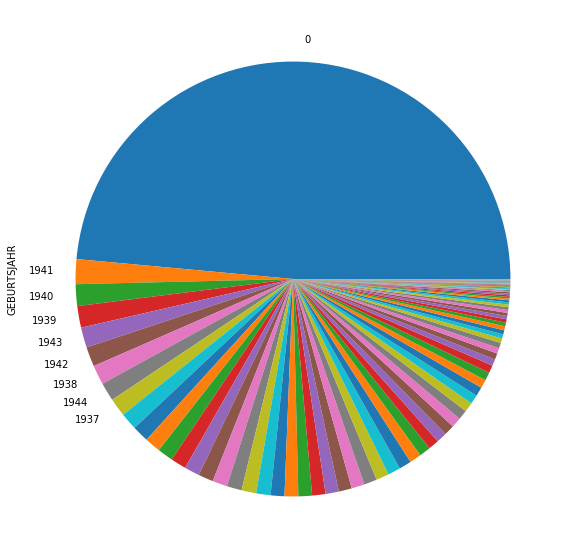

In [51]:
plt.figure(figsize = [10, 10])

_ = customers_df['GEBURTSJAHR'].value_counts()
_ = np.where(_ > 2500, _.index, '')
customers_df['GEBURTSJAHR'].value_counts().plot.pie(labels=_)

plt.show()

Since half of GEBURTSJAHR are all 0, we would like to change it to categorical feature. If we put it in quantative feature, it will affect our normalization process.

#### Check mis-classified `customers_num_annot_attribute` and `customers_num_cat_annot_attribute`

In [52]:
print('check mis-classified customers_num_annot_attribute ...')
for col in customers_num_annot_attribute:
    s = customers_df[col].unique().size
    if s < 50:
        print('{} has total {} values (< 50)'.format(col, s))
        
print()
print('check mis-classified customers_num_cat_annot_attribut e...')
for col in customers_num_cat_annot_attribute:
    s = customers_df[col].unique().size
    if s >= 50:
        print('{} has total {} values (>= 50)'.format(col, s))

check mis-classified customers_num_annot_attribute ...
ANZ_HH_TITEL has total 21 values (< 50)
ANZ_PERSONEN has total 19 values (< 50)
ANZ_TITEL has total 6 values (< 50)
ARBEIT has total 7 values (< 50)
MIN_GEBAEUDEJAHR has total 33 values (< 50)

check mis-classified customers_num_cat_annot_attribut e...


#### To fix the error, we will need to ...

1. CAMEO_DEU_2015: **change '1A', '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', '4D' to integer and 'XX' to NA**
1. CAMEO_DEUG_2015: **change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA**
1. OST_WEST_KZ: **change 'O': 0, 'W': 1**
1. KBA05_MODTEMP: **change 6 to NA**
1. LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB: **chagne 0 to NA**
1. ANZ_HH_TITEL, ANZ_PERSONEN, ANZ_TITEL, ARBEIT, MIN_GEBAEUDEJAHR: **change from quantative to categorical feature**
1. GEBURTSJAHR:**convert fromt quantitative to categrical feature**
1. All other attributes: **convert to integer**

In [53]:
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, ['ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL','ARBEIT', 'MIN_GEBAEUDEJAHR'])
customers_num_cat_annot_attribute = np.union1d(customers_num_cat_annot_attribute, ['ANZ_HH_TITEL', 'ANZ_PERSONEN', 'ANZ_TITEL','ARBEIT', 'MIN_GEBAEUDEJAHR'])

In [54]:
customers_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, ['GEBURTSJAHR'])
customers_num_cat_annot_attribute = np.union1d(customers_num_cat_annot_attribute, ['GEBURTSJAHR'])

In [55]:
assert annot_attr_customers_values.size == customers_bin_cat_annot_attribute.size + customers_str_cat_annot_attribute.size + customers_num_cat_annot_attribute.size + customers_num_annot_attribute.size + customers_unused_annot_attribute.size

create `customers_minus_1_0_unknown_annot_attribute` to hold `minus_1_0_unknown_annot_attribute` in `customers_df`

In [56]:
customers_minus_1_0_unknown_annot_attribute = np.intersect1d(minus_1_0_unknown_annot_attribute, customers_df.columns)

create `customers_minus_1_9_unknown_annot_attribute` to hold `minus_1_9_unknown_annot_attribute` in `customers_df`

In [57]:
customers_minus_1_9_unknown_annot_attribute = np.intersect1d(minus_1_9_unknown_annot_attribute, customers_df.columns)

#### To fix the error, we will need to ...

1. ALTERSKATEGORIE_GROB, ANREDE_KZ, GEBAEUDETYP, HH_EINKOMMEN_SCORE, KBA05_BAUMAX, KBA05_GBZ, KKK, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, REGIOTYP, TITEL_KZ, WOHNDAUER_2008, W_KEIT_KIND_HH: **'-1, 0': -1 == 0 (unknown)**
1. KBA05_ALTER1, KBA05_ALTER2, KBA05_ALTER3, KBA05_ALTER4, KBA05_ANHANG, KBA05_AUTOQUOT, KBA05_CCM1, KBA05_CCM2, KBA05_CCM3, KBA05_CCM4, KBA05_DIESEL, KBA05_FRAU, KBA05_HERST1, KBA05_HERST2, KBA05_HERST3, KBA05_HERST4, KBA05_HERST5, KBA05_HERSTTEMP, KBA05_KRSAQUOT, KBA05_KRSHERST1, KBA05_KRSHERST2, KBA05_KRSHERST3, KBA05_KRSKLEIN, KBA05_KRSOBER, KBA05_KRSVAN, KBA05_KRSZUL, KBA05_KW1, KBA05_KW2, KBA05_KW3, KBA05_MAXAH, KBA05_MAXBJ, KBA05_MAXHERST, KBA05_MAXSEG, KBA05_MAXVORB, KBA05_MOD1, KBA05_MOD2, KBA05_MOD3, KBA05_MOD4, KBA05_MOD8, KBA05_MODTEMP, KBA05_MOTOR, KBA05_MOTRAD, KBA05_SEG1, KBA05_SEG10, KBA05_SEG2, KBA05_SEG3, KBA05_SEG4, KBA05_SEG5, KBA05_SEG6, KBA05_SEG7, KBA05_SEG8, KBA05_SEG9, KBA05_VORB0, KBA05_VORB1, KBA05_VORB2, KBA05_ZUL1, KBA05_ZUL2, KBA05_ZUL3, KBA05_ZUL4, RELAT_AB, SEMIO_DOM, SEMIO_ERL, SEMIO_FAM, SEMIO_KAEM, SEMIO_KRIT, SEMIO_KULT, SEMIO_LUST, SEMIO_MAT, SEMIO_PFLICHT, SEMIO_RAT, SEMIO_REL, SEMIO_SOZ, SEMIO_TRADV, SEMIO_VERT, ZABEOTYP: **'-1, 9': -1 == 9 (unknown)**

##### check `not_annot_attr_customers_values`

In [58]:
customers_df[not_annot_attr_customers_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 93 columns):
AKT_DAT_KL                    145056 non-null float64
ALTERSKATEGORIE_FEIN          139810 non-null float64
ALTER_KIND1                   11766 non-null float64
ALTER_KIND2                   5100 non-null float64
ALTER_KIND3                   1275 non-null float64
ALTER_KIND4                   236 non-null float64
ANZ_KINDER                    145056 non-null float64
ANZ_STATISTISCHE_HAUSHALTE    141725 non-null float64
CAMEO_INTL_2015               141224 non-null object
CJT_KATALOGNUTZER             188439 non-null float64
CJT_TYP_1                     188439 non-null float64
CJT_TYP_2                     188439 non-null float64
CJT_TYP_3                     188439 non-null float64
CJT_TYP_4                     188439 non-null float64
CJT_TYP_5                     188439 non-null float64
CJT_TYP_6                     188439 non-null float64
CUSTOMER_GROUP                1916

#### Check missing value

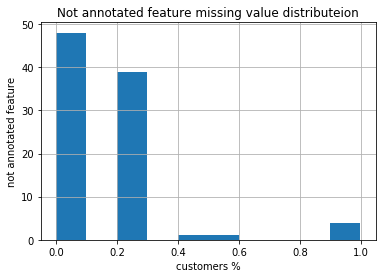

In [59]:
customers_df[not_annot_attr_customers_values].isnull().mean().hist()
plt.xlabel('customers %')
plt.ylabel('not annotated feature')
plt.title('Not annotated feature missing value distributeion')
plt.show()

We can find over 30% csutomers still have missing value among about 6 undocumented features.

create `customers_unused_not_annot_attribute` to hold droped attribute from `not_annot_attr_customers_values`

In [60]:
customers_unused_not_annot_attribute = not_annot_attr_customers_values[customers_df[not_annot_attr_customers_values].isnull().mean() > FEATURE_DROP_RATIO]

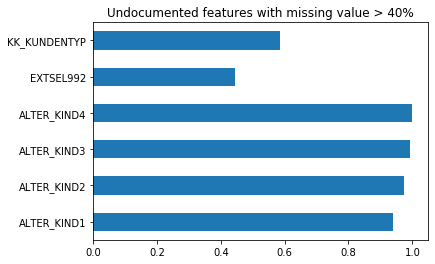

In [61]:
customers_df[customers_unused_not_annot_attribute].isnull().mean().plot.barh()
plt.title('Undocumented features with missing value > 40%')
plt.show()

Since ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') only exist on `customers_df`, we will treat them as unused feature.

In [62]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, only_attr_customers)

#### Ananlyze EINGEFUEGT_AM

convert datetime string to unix second integer

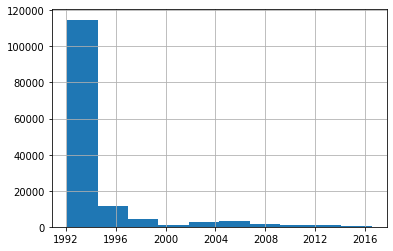

In [63]:
pd.to_datetime(customers_df['EINGEFUEGT_AM']).hist()
plt.show()

We would like to change EINGEFUEGT_AM from datetime string to year based categorical feature.

create `customers_str_cat_not_annot_attribute` to hold string category features  not in `attributes_df` and `values_df`.

In [64]:
customers_str_cat_not_annot_attribute = np.array(['EINGEFUEGT_AM'])

#### Analyze D19_LETZTER_KAUF_BRANCHE

convert string to column index

In [65]:
_ = customers_df['D19_LETZTER_KAUF_BRANCHE'].apply(lambda x: np.where(np.isin(customers_df.columns, x))[0][0] if np.where(np.isin(customers_df.columns, x))[0].size > 0 else -1)

if not np.issubdtype(_.dtype, np.number):
    print('{} is not numberic type'.format(D19_LETZTER_KAUF_BRANCHE))

In [66]:
customers_str_cat_not_annot_attribute = np.union1d(customers_str_cat_not_annot_attribute, ['D19_LETZTER_KAUF_BRANCHE'])

#### Analyze CAMEO_INTL_2015

In [67]:
int_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: int_v.append(x) if isinstance(x, int) else x).dropna().unique()

float_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: float_v.append(x) if isinstance(x, float) else x).dropna().unique()

str_v = []
v1 = customers_df['CAMEO_INTL_2015'].dropna().apply(lambda x: str_v.append(x) if isinstance(x, str) else x).dropna().unique()

int_v = np.unique(np.array(int_v))
float_v = np.unique(np.array(float_v))
str_v = np.unique(np.array(str_v))

if len(int_v) > 0:
    print('CAMEO_INTL_2015 feature has int value: {}'.format(int_v))
if len(float_v) > 0:
    print('CAMEO_INTL_2015 feature has float value: {}'.format(float_v))
if len(str_v) > 0:
    print('CAMEO_INTL_2015 feature has string value: {}'.format(str_v))

CAMEO_INTL_2015 feature has float value: [12. 13. 14. 15. 22. 23. 24. 25. 31. 32. 33. 34. 35. 41. 43. 44. 45. 51.
 52. 54. 55.]
CAMEO_INTL_2015 feature has string value: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']


We will treat same value of float and string data type as the same.

In [68]:
customers_str_cat_not_annot_attribute = np.union1d(customers_str_cat_not_annot_attribute, ['CAMEO_INTL_2015'])

create `customers_num_cat_not_annot_attribute` to hold ordinal categorical attribute from `not_annot_attr_customers_values`

In [69]:
customers_num_cat_not_annot_attribute = np.array([])

create `customers_num_not_annot_attribute` to hold quantative feature from `not_annot_attr_customers_values`

In [70]:
customers_num_not_annot_attribute = np.array([])

#### Analyze int64 dtype values

In [71]:
customers_num_cat_not_annot_attribute = np.union1d(customers_num_cat_not_annot_attribute, customers_df[not_annot_attr_customers_values].select_dtypes(include=['int64']).columns)
customers_num_cat_not_annot_attribute = np.setdiff1d(customers_num_cat_not_annot_attribute, customers_unused_not_annot_attribute)

#### Analyze float64

create `customers_bin_cat_not_annot_attribute` to hold binary category features not in `attributes_df` and `values_df`.

In [72]:
customers_bin_cat_not_annot_attribute = np.array([])

for col in customers_df[not_annot_attr_customers_values].select_dtypes(include=['float64']).columns:
    _ = customers_df[col].dropna().unique()
    if (_.size == 2):
        customers_bin_cat_not_annot_attribute = np.setdiff1d(np.union1d(customers_bin_cat_not_annot_attribute, col), customers_unused_not_annot_attribute)
    elif (_.size < 50):
        customers_num_cat_not_annot_attribute = np.setdiff1d(np.union1d(customers_num_cat_not_annot_attribute, col), customers_unused_not_annot_attribute)
    else:
        customers_num_not_annot_attribute = np.setdiff1d(np.union1d(customers_num_not_annot_attribute, col), customers_unused_not_annot_attribute)

#### Check mis-classified `customers_num_not_annot_attribute` and `customers_num_cat_not_annot_attribute`

In [73]:
print('check mis-classified customers_num_not_annot_attribute ...')
for col in customers_num_not_annot_attribute:
    s = customers_df[col].unique().size
    if s < 50:
        print('{} has total {} values (< 50)'.format(col, s))
        
print()
print('check mis-classified customers_num_cat_not_annot_attribut ...')
for col in customers_num_cat_not_annot_attribute:
    s = customers_df[col].unique().size
    if s >= 50:
        print('{} has total {} values (>= 50)'.format(col, s))

check mis-classified customers_num_not_annot_attribute ...

check mis-classified customers_num_cat_not_annot_attribut ...
LNR has total 191652 values (>= 50)


LNR is like serial number

In [74]:
customers_df.shape[0] == customers_df['LNR'].unique().size

True

In [75]:
customers_unused_not_annot_attribute = np.union1d(customers_unused_not_annot_attribute, 'LNR')
customers_num_cat_not_annot_attribute = np.setdiff1d(customers_num_cat_not_annot_attribute, 'LNR')

#### To fix the error, we will need to ...

1. ONLINE_PURCHASE, CUSTOMER_GROUP, PRODUCT_GROUP: **drop (not exist in general population)**
1. ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, EXTSEL992, KK_KUNDENTYP: **drop (missing value > 40%)**
1. EINGEFUEGT_AM: **convert datetime string to year based categorical feature**
1. D19_LETZTER_KAUF_BRANCHE: **change feature string to column index**
1. CAMEO_INTL_2015: **change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA**
1. LNR: **drop (like serial number)**
1. All other attribute: **convert to integer**

In [76]:
assert not_annot_attr_customers_values.size == customers_bin_cat_not_annot_attribute.size + customers_str_cat_not_annot_attribute.size + customers_num_cat_not_annot_attribute.size + customers_num_not_annot_attribute.size + customers_unused_not_annot_attribute.size

#### ROW Viewpoint

#### Check missing value

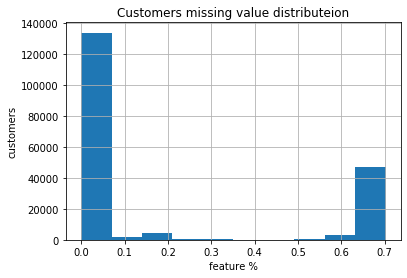

In [77]:
customers_df.isnull().mean(axis=1).hist()
plt.xlabel('feature %')
plt.ylabel('customers')
plt.title('Customers missing value distributeion')
plt.show()

Around 50000 customers (26.76%) have missing value over 40% feature.

In [78]:
customers_df[customers_df.isnull().mean(axis=1) > .3].shape[0]/customers_df.shape[0]

0.2675735186692547

#### To fix the error, we will need to ...

1. Drop customers with **missing value feature % > 30%**

### Data Exploration - azdias vs. customers

In [79]:
azdias_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


#### Check missing value

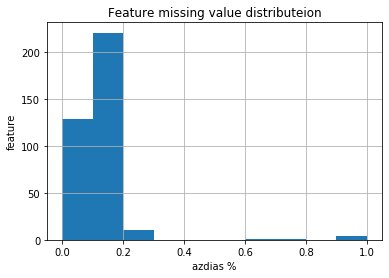

In [80]:
azdias_df.isnull().mean().hist()
plt.xlabel('azdias %')
plt.ylabel('feature')
plt.title('Feature missing value distributeion')
plt.show()

Over 30% general population have around 10 feature have missing value.

create `annot_attr_azdias_values` to hold all documented feature in general population.

In [81]:
annot_attr_azdias_values = annot_attr_customers_values

create `not_annot_attr_azdias_values` to hold all undocumented feature in general population.

In [82]:
not_annot_attr_azdias_values = np.setdiff1d(not_annot_attr_customers_values, only_attr_customers)

In [83]:
azdias_unused_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, annot_attr_azdias_values)

In [84]:
azdias_unused_not_annot_attribute = np.intersect1d(azdias_df.columns[azdias_df.isnull().mean() > FEATURE_DROP_RATIO].values, not_annot_attr_azdias_values)
azdias_unused_not_annot_attribute = np.setdiff1d(azdias_unused_not_annot_attribute, only_attr_customers)
azdias_unused_not_annot_attribute = np.union1d(azdias_unused_not_annot_attribute, 'LNR')

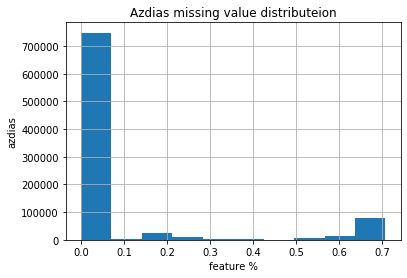

In [85]:
azdias_df.isnull().mean(axis=1).hist()
plt.xlabel('feature %')
plt.ylabel('azdias')
plt.title('Azdias missing value distributeion')
plt.show()

Around 100000 (11.14%) general population have missing value over 30% feature.

In [86]:
azdias_df[azdias_df.isnull().mean(axis=1) > .4].shape[0]/azdias_df.shape[0]

0.11137978122149277

#### Ananlyze `azdias_bin_cat_annot_attribute`

create `azdias_bin_cat_annot_attribute` to hold binary categorical feature of general population

In [87]:
azdias_bin_cat_annot_attribute = np.setdiff1d(customers_bin_cat_annot_attribute, azdias_unused_annot_attribute)

for attr in azdias_bin_cat_annot_attribute:
    v = np.setdiff1d(azdias_df[attr].dropna().unique(), customers_df[attr].dropna().unique())
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

#### Ananlyze `azdias_str_cat_annot_attribute`

create `azdias_str_cat_annot_attribute` to hold string categorical feature of general population

In [88]:
azdias_str_cat_annot_attribute = np.setdiff1d(customers_str_cat_annot_attribute, azdias_unused_annot_attribute)

for attr in azdias_str_cat_annot_attribute:
    v = np.setdiff1d(azdias_df[attr].dropna().unique(), customers_df[attr].dropna().unique())
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

#### Ananlyze `azdias_num_cat_annot_attribute`

create `azdias_num_cat_annot_attribute` to hold quantitative categorical feature of general population

In [89]:
azdias_num_cat_annot_attribute = np.setdiff1d(customers_num_cat_annot_attribute, azdias_unused_annot_attribute)

for attr in azdias_num_cat_annot_attribute:
    v1 = azdias_df[attr].dropna().apply(lambda x: int(x) if x != 'X' else np.nan).dropna().unique()
    v2 = customers_df[attr].dropna().apply(lambda x: int(x) if x != 'X' else np.nan).dropna().unique()
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))
        v3 = values_df[values_df.Attribute == attr]['Value'].dropna().values
        if v3.size > 1:
            if isinstance(v3[0], str):
                v3 = np.hstack(values_df[values_df.Attribute == attr]['Value'].apply(lambda x: x if not isinstance(x, str) else x.split(','))).astype(int)
            if np.setdiff1d(v1, v3).size > 0:
                print('-> undocumented')

ALTER_HH different with customers_df : [1]
ANZ_HH_TITEL different with customers_df : [16]
ANZ_PERSONEN different with customers_df : [17 18 20 22 23 29 31 35 37 38 40 45]
ANZ_TITEL different with customers_df : [4 6]
D19_BANKEN_ONLINE_QUOTE_12 different with customers_df : [1]
GEBAEUDETYP different with customers_df : [5]
GEBURTSJAHR different with customers_df : [1904 1905 1906 1907]
KBA13_AUTOQUOTE different with customers_df : [0]
KBA13_KRSAQUOT different with customers_df : [0]
KBA13_KRSHERST_AUDI_VW different with customers_df : [0]
KBA13_KRSHERST_BMW_BENZ different with customers_df : [0]
KBA13_KRSHERST_FORD_OPEL different with customers_df : [0]
KBA13_KRSSEG_KLEIN different with customers_df : [0]
ORTSGR_KLS9 different with customers_df : [0]
-> undocumented
TITEL_KZ different with customers_df : [2]


#### Ananlyze `azdias_num_annot_attribute`

create `azdias_num_annot_attribute` to hold quantitative feature of general population

In [90]:
azdias_num_annot_attribute = np.setdiff1d(customers_num_annot_attribute, azdias_unused_annot_attribute)

for attr in azdias_num_annot_attribute:
    v1 = azdias_df[attr].dropna().unique()
    v2 = customers_df[attr].dropna().unique()
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

ANZ_HAUSHALTE_AKTIV different with customers_df : [130. 132. 144. 151. 152. 162. 164. 166. 168. 169. 174. 175. 176. 177.
 180. 183. 184. 187. 191. 193. 194. 197. 198. 201. 205. 206. 208. 213.
 214. 215. 216. 218. 220. 224. 225. 226. 228. 231. 232. 236. 237. 241.
 242. 244. 247. 249. 250. 255. 256. 260. 263. 266. 272. 280. 283. 285.
 293. 314. 316. 317. 318. 326. 328. 333. 346. 347. 353. 377. 378. 404.
 414. 430. 438. 445. 515. 536. 595.]
KBA13_ANZAHL_PKW different with customers_df : [ 0.  1.  2.  3.  4.  7.  9. 17. 19. 24. 30.]


#### Ananlyze `azdias_bin_cat_not_annot_attribute`

create `azdias_bin_cat_not_annot_attribute` to hold undocumented binary categorical feature of general population

In [91]:
azdias_bin_cat_not_annot_attribute = np.setdiff1d(customers_bin_cat_not_annot_attribute, azdias_unused_not_annot_attribute)

for attr in azdias_bin_cat_not_annot_attribute:
    v = np.setdiff1d(azdias_df[attr].dropna().unique(), customers_df[attr].dropna().unique())
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

#### Ananlyze `azdias_str_cat_not_annot_attribute`

create `azdias_str_cat_not_annot_attribute` to hold undocumented string categorical feature of general population

In [92]:
azdias_str_cat_not_annot_attribute = np.setdiff1d(customers_str_cat_not_annot_attribute, azdias_unused_not_annot_attribute)

for attr in azdias_str_cat_not_annot_attribute:
    if attr == 'CAMEO_INTL_2015':
        v1 = azdias_df[attr].dropna().apply(lambda x: int(x) if x != 'XX' else np.nan).dropna().unique()
        v2 = customers_df[attr].dropna().apply(lambda x: int(x) if x != 'XX' else np.nan).dropna().unique()
    else:
        v1 = np.setdiff1d(azdias_df[attr].dropna().unique(), customers_df[attr].dropna().unique())
        v2 = np.setdiff1d(customers_df[attr].dropna().unique(), customers_df[attr].dropna().unique())
    
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

EINGEFUEGT_AM different with customers_df : ['1991-06-17 00:00:00' '1991-08-30 00:00:00' '1992-12-17 00:00:00' ...
 '2016-04-20 00:00:00' '2016-05-02 00:00:00' '2016-05-09 00:00:00']


#### Ananlyze `azdias_num_cat_not_annot_attribute`

create `azdias_num_cat_not_annot_attribute` to hold undocumented quantitative categorical feature of general population

In [93]:
azdias_num_cat_not_annot_attribute = np.setdiff1d(customers_num_cat_not_annot_attribute, azdias_unused_not_annot_attribute)

for attr in azdias_num_cat_not_annot_attribute:
    v1 = azdias_df[attr].dropna().unique()
    v2 = customers_df[attr].dropna().unique()
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

ALTERSKATEGORIE_FEIN different with customers_df : [1.]
ANZ_KINDER different with customers_df : [ 9. 11.]
D19_TELKO_ONLINE_QUOTE_12 different with customers_df : [7.]
D19_VERSI_ONLINE_QUOTE_12 different with customers_df : [3. 6. 8. 9.]
EINGEZOGENAM_HH_JAHR different with customers_df : [1900. 1904. 1971. 1984.]


#### Ananlyze `azdias_num_not_annot_attribute`

create `azdias_num_not_annot_attribute` to hold undocumented quantitative feature of general population

In [94]:
azdias_num_not_annot_attribute = np.setdiff1d(customers_num_not_annot_attribute, azdias_unused_not_annot_attribute)

for attr in azdias_num_not_annot_attribute:
    v1 = azdias_df[attr].dropna().unique()
    v2 = customers_df[attr].dropna().unique()
    v = np.setdiff1d(v1, v2)
    if v.size > 0:
        print('{} different with customers_df : {}'.format(attr, v))

ANZ_STATISTISCHE_HAUSHALTE different with customers_df : [121. 133. 138. 139. 148. 151. 154. 157. 162. 164. 165. 166. 169. 171.
 173. 175. 176. 177. 182. 185. 190. 194. 197. 198. 203. 204. 205. 214.
 216. 217. 227. 229. 234. 237. 238. 241. 242. 243. 244. 245. 257. 262.
 264. 286. 303. 319. 328. 336. 342. 353. 366. 367. 369. 445. 449.]


#### To fix the error, we will need to ...

1. ORTSGR_KLS9: **change 0 to NA (undocumented in values_df)**

In [95]:
assert annot_attr_azdias_values.size == azdias_bin_cat_annot_attribute.size + azdias_str_cat_annot_attribute.size + azdias_num_cat_annot_attribute.size + azdias_num_annot_attribute.size + azdias_unused_annot_attribute.size

In [96]:
assert not_annot_attr_azdias_values.size == azdias_bin_cat_not_annot_attribute.size + azdias_str_cat_not_annot_attribute.size + azdias_num_cat_not_annot_attribute.size + azdias_num_not_annot_attribute.size + azdias_unused_not_annot_attribute.size

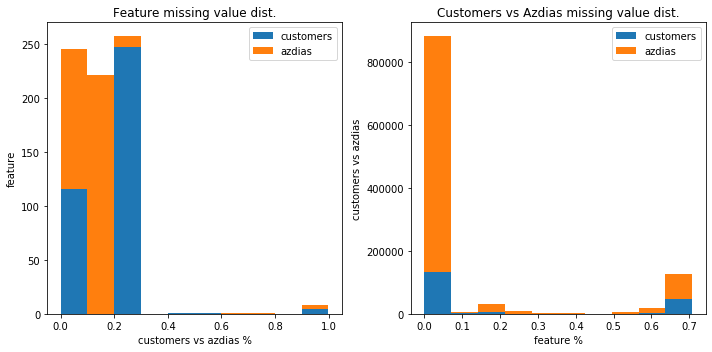

In [97]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((customers_df.isnull().mean(),azdias_df.isnull().mean()), stacked=True, label=['customers','azdias'])
plt.xlabel('customers vs azdias %')
plt.ylabel('feature')
plt.title('Feature missing value dist.')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((customers_df.isnull().mean(axis=1),azdias_df.isnull().mean(axis=1)), stacked=True, label=['customers','azdias'])
plt.xlabel('feature %')
plt.ylabel('customers vs azdias')
plt.title('Customers vs Azdias missing value dist.')
plt.legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

#### What we want to do here ...

1. Drop sample and feature with large missing value
1. Convert string to number and identify NA
1. Change possible ambiguous unknown value to one single value
1. Fill in missing value with median
1. Quantative feature normalization
1. Remove outlier

In [98]:
# dictionary to hold all type of annotated features
annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_annot_attribute,
    'str_cat': azdias_str_cat_annot_attribute,
    'num_cat': azdias_num_cat_annot_attribute,
    'num': azdias_num_annot_attribute,
    'unused': azdias_unused_annot_attribute
}

# dictionary to hold all type of un-annotated features
not_annot_attr_azdias_values_dict = {
    'bin_cat': azdias_bin_cat_not_annot_attribute,
    'str_cat': azdias_str_cat_not_annot_attribute,
    'num_cat': azdias_num_cat_not_annot_attribute,
    'num': azdias_num_not_annot_attribute,
    'unused': azdias_unused_not_annot_attribute
}

unknown_annot_attribute_dict = {
    'minus_1_0': customers_minus_1_0_unknown_annot_attribute,
    'minus_1_9': customers_minus_1_9_unknown_annot_attribute
}

CUSTOMER_DROP_RATIO = .3 ## customer drop ration

new_customers_df = customers_df.copy()
new_azdias_df = azdias_df.copy()

In [99]:
def drop(df, customer_drop_ratio=CUSTOMER_DROP_RATIO, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    customer_drop_ratio - drop ratio for customer
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Drop customers with drop_ratio.
    '''
    ## drop customer
    df = df.loc[df.isnull().mean(axis=1) < customer_drop_ratio]
    
    ## drop ferature
    cols = [v for k in annot_dict.keys() for v in annot_dict[k]]
    cols += [v for k in not_annot_dict.keys() for v in not_annot_dict[k]]
    cols = np.setdiff1d(cols, annot_dict['unused'])
    cols = np.setdiff1d(cols, not_annot_dict['unused'])
    df = df[cols]
    
    return df

In [100]:
new_azdias_df = drop(new_azdias_df)

In [101]:
new_customers_df = drop(new_customers_df)

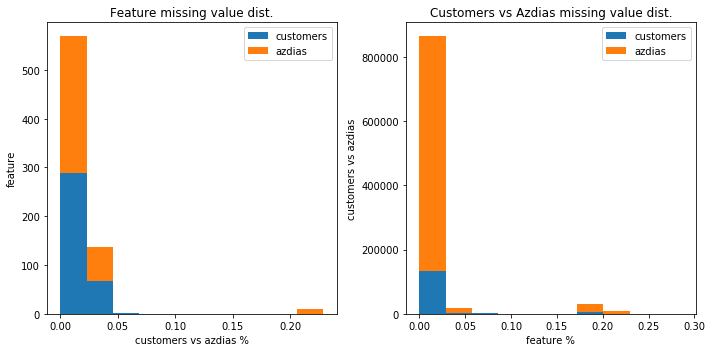

In [102]:
plt.figure(figsize = [10, 5])

plt.subplot(1, 2, 1)
plt.hist((new_customers_df.isnull().mean(),new_azdias_df.isnull().mean()), stacked=True, label=['customers','azdias'])
plt.xlabel('customers vs azdias %')
plt.ylabel('feature')
plt.title('Feature missing value dist.')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist((new_customers_df.isnull().mean(axis=1),new_azdias_df.isnull().mean(axis=1)), stacked=True, label=['customers','azdias'])
plt.xlabel('feature %')
plt.ylabel('customers vs azdias')
plt.title('Customers vs Azdias missing value dist.')
plt.legend()

plt.tight_layout()
plt.show()

We can find customers missing value been bounded by generation population, which means this is a sufficient drop.

In [103]:
def formatit(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    attr_dict - dictionary with feature type
    
    Description: Change un-documented value to NA. Try to match 'DIAS Attributes - Values 2017.xlsx' Value field.
    '''
    for k in annot_dict.keys():
        for v in annot_dict[k]:
            if v == 'OST_WEST_KZ':

                # change 'O': 0, 'W': 1
                df[v] = df[df[v].notna()][v].apply(lambda x: 1 if x == 'W' else 0)
            elif v == 'CAMEO_DEU_2015':

                # change '1A', '5D', '4C', '7B', '3B', '1D', '9E', '2D', '4A', '6B', '9D', '8B', '5C', '9C', '4E', '6C', '8C', '8A', '5B', '9B', '3D', '2A', '3C', '5F', '7A', '1E', '2C', '7C', '5A', '2B', '6D', '7E', '5E', '6E', '3A', '9A', '4B', '1C', '1B', '6A', '8D', '7D', '6F', '4D' to integer and 'XX' to NA
                values = customers_df['CAMEO_DEU_2015'].unique()
                df[v] = df[df[v].notna()][v].apply(lambda x: np.where(values == x)[0][0] if isinstance(x, str) and x != 'XX'  else np.nan)
            elif v == 'CAMEO_DEUG_2015':

                # change '1', '2', '3', '4', '5', '6', '7', '8', '9' to integer, and 'X' to NA
                df[v] = df[df[v].notna()][v].apply(lambda x: (isinstance(x, int) and x) or (x == 'X' and np.nan) or (int(x)))
            elif v == 'KBA05_MODTEMP':

                # change 6 to NA
                df[v] = df[df[v].notna()][v].apply(lambda x: np.nan if x == 6 else int(x))
            elif np.isin(v, ['LP_FAMILIE_FEIN',
                            'LP_FAMILIE_GROB',
                            'LP_LEBENSPHASE_FEIN',
                            'LP_LEBENSPHASE_GROB']):

                # change 0 to NA
                df[v] = df[df[v].notna()][v].apply(lambda x: np.nan if x == 0 else int(x))

            elif v == 'ORTSGR_KLS9':

                # change 0 to NA (undocumented in values_df)'
                df[v] = df[df[v].notna()][v].apply(lambda x: np.nan if x == 0 else int(x))
            else:

                # All other attribute: convert to integer
                df[v] = df[df[v].notna()][v].apply(lambda x: int(x));
    
    for k in not_annot_dict.keys():
        if k != 'unused':
            for v in not_annot_dict[k]:
                if v == 'EINGEFUEGT_AM':

                    # convert datetime string to year based categorical feature
                    df[v] = df[df[v].notna()][v].apply(lambda x: pd.to_datetime(x).year)
                elif v == 'D19_LETZTER_KAUF_BRANCHE':

                    # change feature string to column index
                    df[v] = df[df[v].notna()][v].apply(lambda x: np.where(customers_df.columns == x)[0][0] if x != 'D19_UNBEKANNT' else 0)
                elif v == 'CAMEO_INTL_2015':

                    # change '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35', '23', '12', '44', '41', '52', '31', '13', '34', '32', '33' to integer, and 'XX' to NA
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x) if x != 'XX' else np.nan)
                else:

                    # All other attribute: convert to integer
                    df[v] = df[df[v].notna()][v].apply(lambda x: int(x))
                
    return df

In [104]:
new_azdias_df = formatit(new_azdias_df)

In [105]:
new_customers_df = formatit(new_customers_df)

In [106]:
new_customers_df.to_pickle('new_customers_df_formatit.pickle')
new_azdias_df.to_pickle('new_azdias_df_formatit.pickle')

In [107]:
new_customers_df_formatit = pd.read_pickle("new_customers_df_formatit.pickle")
new_azdias_df_formatit = pd.read_pickle("new_azdias_df_formatit.pickle")

In [108]:
def unknown(df, unknown_dict=unknown_annot_attribute_dict):
    '''
    INPUT:
    df - pandas dataframe
    unknown_dict - dictionary to hold all type of unknown string features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: convert all type of unknown value to 1 single value.
    '''
    for v in unknown_dict['minus_1_0']:
        df[v] = df[df[v].notna()][v].apply(lambda x: -1 if (x == -1 or x == 0) else x)
        
    for v in unknown_dict['minus_1_9']:
        df[v] = df[df[v].notna()][v].apply(lambda x: -1 if (x == -1 or x == 9) else x)
    
    return df

In [109]:
new_customers_df = unknown(new_customers_df)
new_azdias_df = unknown(new_azdias_df)

In [110]:
def fillna(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Fill every NA field a value.
    '''
    for k in annot_dict.keys():
        if k != 'unused':
            for v in annot_dict[k]:
                df[v] = df[v].fillna(df[v].median())
            
    for k in not_annot_dict.keys():
        if k != 'unused':
            for v in not_annot_dict[k]:
                df[v] = df[v].fillna(df[v].median())
    
    return df

In [111]:
new_azdias_df = fillna(new_azdias_df)

In [112]:
new_customers_df = fillna(new_customers_df)

In [113]:
new_customers_df.to_pickle('new_customers_df_fillna.pickle')
new_azdias_df.to_pickle('new_azdias_df_fillna.pickle')

In [114]:
new_customers_df_fillna = pd.read_pickle("new_customers_df_fillna.pickle")
new_azdias_df_fillna = pd.read_pickle("new_azdias_df_fillna.pickle")

#### Check quantative feature relationship

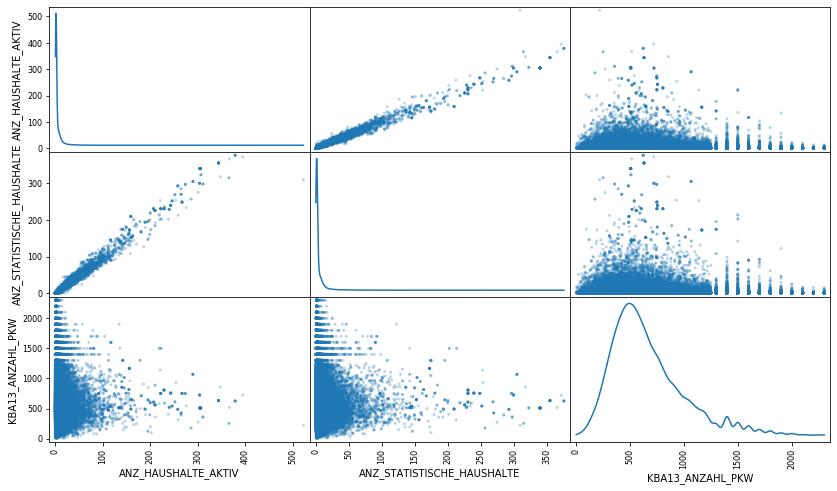

In [116]:
_ = new_customers_df[np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])]
pd.plotting.scatter_matrix(_, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

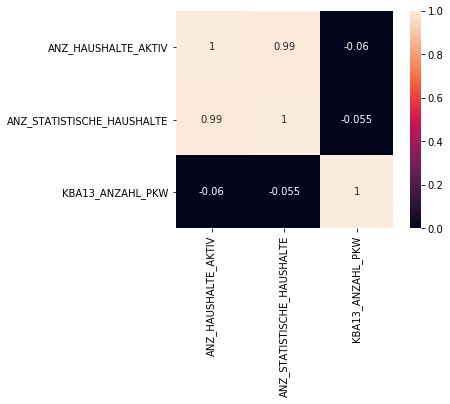

In [117]:
uniform_data = _.corr()
sns.heatmap(uniform_data, vmin=0, vmax=1, annot=True, square=True)
plt.show()

#### To fix the error, we will need to ..

1. ANZ_HAUSHALTE_AKTIV, ANZ_STATISTISCHE_HAUSHALTE: **log transform(right skewed data)**
3. **ANZ_HAUSHALTE_AKTIV and ANZ_STATISTISCHE_HAUSHALTE has very high corelation**

__NOTE__: ANZ_HAUSHALTE_AKTIV: number of households in the building

__NOTE__: ANZ_STATISTISCHE_HAUSHALTE: un-documented

In [118]:
def normalize(df):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Normalize numeric feature to a range.
    '''
    df['ANZ_HAUSHALTE_AKTIV'] = np.log1p(df['ANZ_HAUSHALTE_AKTIV'])
    df['ANZ_STATISTISCHE_HAUSHALTE'] = np.log1p(df['ANZ_STATISTISCHE_HAUSHALTE'])
    
    return df

In [119]:
new_customers_df = normalize(new_customers_df)

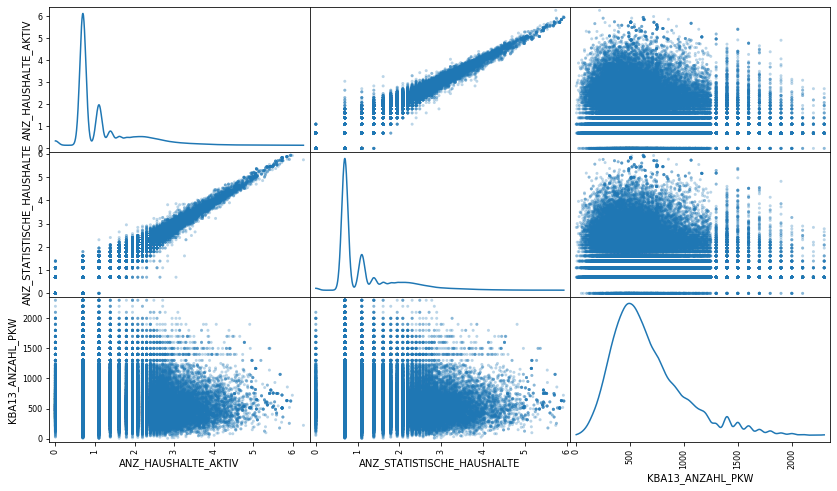

In [121]:
_ = new_customers_df[np.union1d(annot_attr_azdias_values_dict['num'], not_annot_attr_azdias_values_dict['num'])]
pd.plotting.scatter_matrix(_, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [122]:
new_azdias_df = normalize(new_azdias_df)

Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In [127]:
def remove_outlier(df, annot_dict=annot_attr_azdias_values_dict, not_annot_dict=not_annot_attr_azdias_values_dict, ratio=.3):
    '''
    INPUT:
    df - pandas dataframe
    annot_dict - dictionary to hold all type of annotated features
    not_annot_dict - dictionary to hold all type of un-annotated features
    ratio - ratio feature are all outlier will be considered as true outlier
    
    OUTPUT:
    df - pandas dataframe
    
    Description: Remove abnormal value
    '''
    outliers  = []
    
    n_feature = np.union1d(annot_dict['num'], not_annot_dict['num']).size

    # For each feature find the data points with extreme high or low values
    for feature in np.union1d(annot_dict['num'], not_annot_dict['num']):
    
        # Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(df[feature], 25)

        # Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(df[feature], 75)

        # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3-Q1)

        # Display the outliers
#         print("Data points considered outliers for the feature '{}':".format(feature))
        outlier = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]

        outliers += list(outlier.index)

    # Select the indices for data points you wish to remove
    outliers  = list(set([x for x in outliers if outliers.count(x) > n_feature*ratio]))

    print("drop {} outliers for over {} features: ".format(len(outliers), n_feature*ratio))
    df.drop(outliers, inplace=True)
    
    return df

In [128]:
new_azdias_df = remove_outlier(new_azdias_df)

drop 39317 outliers for over 0.8999999999999999 features: 


In [129]:
new_customers_df = remove_outlier(new_customers_df)

drop 17610 outliers for over 0.8999999999999999 features: 


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Feature Transformation

In [130]:
new_azdias_df = pd.read_pickle("new_azdias_df_fillna.pickle")

In [131]:
np.where(new_azdias_df.columns == 'GEBURTSJAHR')

(array([107]),)

In [132]:
from sklearn.decomposition import PCA

# Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA().fit(new_azdias_df[annot_attr_customers_values])

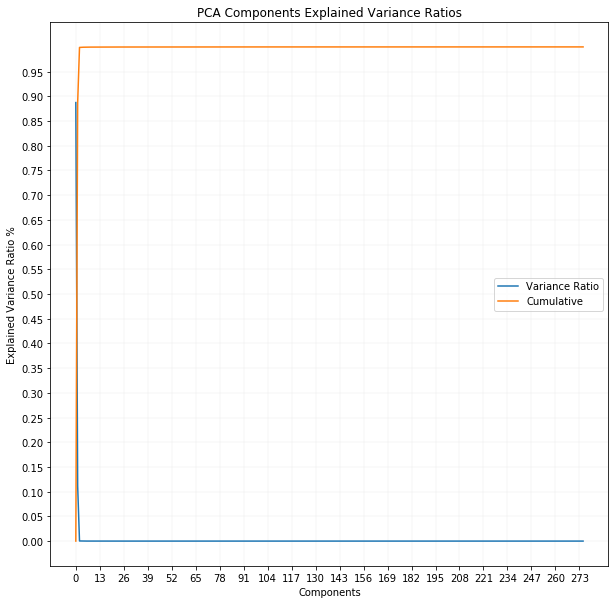

In [133]:
def show_pca(pca):
    """    
    INPUT:
        pca: an sklearn.decomposition.pca.PCA object    
    
    OUTPUT:
        None (visualizes a plot)
    
    DESCRIPTION:
        Visualize the curves of the explained variance ratio for each component and the cumulative ratios
    """
    cumulative_ratios=np.zeros(len(pca.explained_variance_ratio_))
    
    for i in range(len(pca.explained_variance_ratio_)):
        cumulative_ratios[i]=np.sum(pca.explained_variance_ratio_[:i])
        
    plt.figure(figsize=(10,10))
    
    plt.plot(pca.explained_variance_ratio_)
    plt.plot(cumulative_ratios)
    
    plt.xlabel("Components")
    plt.ylabel("Explained Variance Ratio %")
    plt.title("PCA Components Explained Variance Ratios")
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.xticks(np.arange(0, len(pca.explained_variance_ratio_)+2, step= (len(pca.explained_variance_ratio_) // 20)))
    plt.grid(linewidth=0.1)
    plt.legend(['Variance Ratio', 'Cumulative'], loc='center right')
    
show_pca(pca)

In [ ]:
new_azdias_df.columns[np.where(np.round(pca.components_[0], 4) < -.9)]

In [ ]:
new_azdias_df.columns[np.where(pca.components_[0] > .8)]

In [ ]:
new_azdias_df['KBA13_ANTG4'].

In [ ]:
np.sum(pca.explained_variance_ratio_[:3])

In [ ]:
# Transform log_samples using the PCA fit above
pca_samples = pca.transform(new_customers_df)

In [ ]:
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    print(variance_ratios)

#     # Create a bar plot visualization
#     fig, ax = plt.subplots(figsize = (14,8))

#     # Plot the feature weights as a function of the components
#     components.plot(ax = ax, kind = 'bar');
#     ax.set_ylabel("Feature Weights")
#     ax.set_xticklabels(dimensions, rotation=0)


#     # Display the explained variance ratios
#     for i, ev in enumerate(pca.explained_variance_ratio_):
#         ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
#     return pd.concat([variance_ratios, components], axis = 1)
    return good_data

In [ ]:
# Generate PCA results plot
pca_results = pca_results(new_azdias_df, pca)

### Clustering

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')